# prologue

### set up notebook and load package

In [1]:
# for notebook plotting
%matplotlib inline 

# load what we need
import time
import timeit
import numpy as np
import CHIRPS.structures as strcts
import CHIRPS.datasets as ds
import CHIRPS.datasets_proprietary as dsp
import CHIRPS.routines as rt

# demo datasets that ship with package. all from UCI unless stated otherwise
# import CHIRPS.datasets as ds
# ds.adult_data, ds.adult_samp_data, ds.adult_small_samp_data Large dataset ships with manageable sub samples
# ds.bankmark_data, ds.bankmark_samp_data
# ds.car_data
# ds.cardio_data this is the cardiotocography dataset
# ds.credit_data
# ds.german_data
# ds.lending_data, ds.lending_samp_data, ds.lending_small_samp_data, ds.lending_tiny_samp_data from Kaggle. see datasets_from_source file for links
# ds.nursery_data, ds.nursery_samp_data
# ds.rcdv_data, ds.rcdv_samp_data from US government see datasets_from_source file for links

### common config - can be ommitted if defaults are OK

In [2]:
# location to save results
project_dir = '/datadisk/whiteboxing/2020'
# project_dir = 'V:\\whiteboxing\\2020' # defaults to a directory "whiteboxing" in the working directory
# project_dir = 'C:\\Users\\Crutt\\Documents\\whiteboxing\\2020'

random_state_splits = 123 # one off for splitting the data into test / train
random_state = 123 # for everything else - e.g. building a new rf with same data

# Build a Random Forest Model to Predict and Explain
First, a wrapper is created for the dataset. Use one that ships with the package, or create your own.
Then split the data into training and (hold out) test set using the convenience functions in the package. These return an object that contain the split data in various representations, such as Pandas DataFrames and encoded, sparse matrices.

/home/julianhatwell/anaconda3/envs/B3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


using previous tuning parameters
Best OOB Accuracy Estimate during tuning: 1.0000
Best parameters:{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5, 'random_state': 123}

Confusion matrix, without normalization
[[164   0]
 [  0 354]]


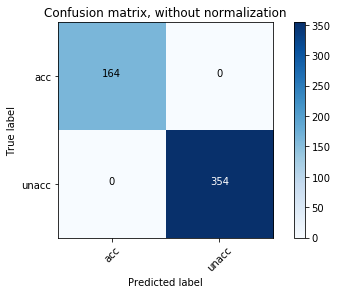

Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


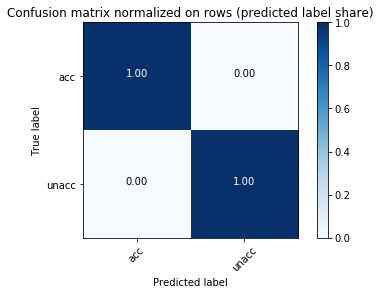

In [13]:
# load one of the included datasets
# project_dir will default to directory name CHIRPS in the working directory if not given
# random_state will default to 123
override_tuning = False
mydata = ds.car(random_state=random_state_splits, project_dir=project_dir)

meta_data = mydata.get_meta()
save_path = meta_data['get_save_path']()

# split the data. here using a basic sampling method.
# the returned object is a wrapper class that contains
# the train and test splits for X and y

# also the the encoded versions of X_train and X_test that the rf will use
# this is because we prefer onehot encoded over allowing categorical vars to be represented as integer
# scikit would treat these as ordinal, which is inappropriate

# also some meta-data: priors for y, the indexes from the input data

# also some convenience functions for leave-one-out testing

# train test split - one off hard-coded random state.
# random state can be ommitted 
# and will default to the state held in the dataset container
# which defaults to 123 if ommitted in the constructor
train_index, test_index = mydata.get_tt_split_idx(random_state=random_state_splits)
# optionally, indexes can be ommitted and will default to scikit's train_test_split method
tt = mydata.tt_split(train_index, test_index)

# CHOOSE ONE
# model = 'RandomForest'
# model = 'AdaBoost1' # SAMME
# model = 'AdaBoost2' # SAMME.R
model = 'GBM'

# decide if to run the whole tuning routine again (long for Adaboost)
# RF routine has a default tuning grid, so can leave as None, or come up with some other options
tuning = {'grid' : None, 'override' : override_tuning}
if model == 'RandomForest':
    which_trees = 'majority'
    tuning.update({'grid' : {'n_estimators': [(i + 1) * 200 for i in range(8)],
                            'max_depth' : [32]}})

elif model in ('AdaBoost1', 'AdaBoost2'):
    if model == 'AdaBoost1':
        # classic (and multi-class) AdaBoost
        algo = 'SAMME'
        which_trees = 'majority'
    else:
        algo = 'SAMME.R'
        which_trees = 'conf_weighted'
    max_depth = [i for i in range(1, 5)]
    tuning.update({'grid' : {'base_estimator' : [rt.DecisionTreeClassifier(max_depth=d) for d in max_depth],
                            'n_estimators': [(i + 1) * 200 for i in range(8)], 'algorithm': [algo]}})
    
else: # GBM - not fully implemented yet
    tuning.update({'grid' : {'subsample' : [0.5],
                        'n_estimators': [i * 200 for i in range(1, 9)],
                        'max_depth' : [i for i in range(1, 5)],
                        'learning_rate': np.full(4, 10.0)**[i for i in range(-3, 1)]}})

rf = rt.forest_prep(ds_container=tt,
                    meta_data=meta_data,
                    override_tuning=override_tuning,
                    model=model,
                    tuning_grid=tuning['grid'],
                    save_path=save_path,
                    plot_cm=True, plot_cm_norm=True)

# Preparing unseen data

Again note:
test set has never been "seen" by random forest during training
test set has been only used to assess model (random forest) accuracy - no additional tuning after this
test set has not be involved in generating the explainer

## optional: memory and computation cost management
#### CHIRPS is time economical but memory intensive to compute for lots of instances at once
option 1: choose a smaller number of instances to explain

In [14]:
# control for async processes - each tree walk can be done in its own core
# and so can each explanation (e.g. rule conditions merge by hill-climbing)
# these will default to false if not passed explicitly to the explainer function
# on a multi-core machine there should be a good speed up for large batches
# when the batch_size advantage exceeds the overhead of setting up multi-processing
# timings will be printed to screen so you can see if it helps
forest_walk_async=False
explanation_async=False

# how many instances to explain in total from a test/unseen set
# doesn't matter if you don't know how large the dataset is
# this function prevents you maxing out, or put n_instances = None for whole dataset
n_instances = rt.n_instance_ceiling(ds_container=tt, n_instances=10)

# this gets the next batch out of the data_split_container according to the required number of instances
# all formats can be extracted, depending on the requirement
# unencoded, encoded (sparse matrix is the type returned by scikit), ordinary dense matrix also available
tt.current_row_test = 3
instances, _, instances_enc, instances_enc_matrix, labels = tt.get_next(n_instances, which_split='test') # default

option 2: just run the whole test set

In [15]:
# instances = tt.X_test; instances_enc = tt.X_test_enc; instances_enc_matrix = tt.X_test_enc_matrix; labels = tt.y_test

## Make predictions from the decision forest on the unseen data
Important point, no compromise on model accuracy

In [16]:
# get all the model predictions for the test instance(s) we're looking at
preds_idx = labels.index
preds = rf.predict(X=instances_enc)

# CHIRPS Step 1:
## Extract Tree Prediction Paths
### Fit a forest_walker object to the dataset and decision forest
This is a wrapper will extracts the paths of all the given instances. For CHIRPS, we want a large sample. The whole training set or other representative sample will do.

It can also report interesting statistics (treating the forest as a set of random tree-structured variables).

In [17]:
# wrapper object needs the decision forest itself and the dataset meta data
if model == 'GBM':
    f_walker = strcts.regression_trees_walker(forest = rf, meta_data=meta_data)
else:
    f_walker = strcts.classification_trees_walker(forest = rf, meta_data=meta_data)

In [18]:
print('Walking forest for ' + str(len(labels)) + ' instances... (please wait)')

# set the timer
forest_walk_start_time = timeit.default_timer()

# do the walk - creates a paths_container (even for just one instance) as a new property
# requires the X instances in a matrix (dense, ordinary numpy matrix) - this is available in the data_split_container
f_walker.forest_walk(instances = instances_enc_matrix
                    , labels = preds # we're explaining the prediction, not the true label!
                    , forest_walk_async = forest_walk_async)

# stop the timer
forest_walk_end_time = timeit.default_timer()
forest_walk_elapsed_time = forest_walk_end_time - forest_walk_start_time

print('Forest Walk with async = ' + str(forest_walk_async))
print('Forest Walk time elapsed:', "{:0.4f}".format(forest_walk_elapsed_time), 'seconds')

Walking forest for 10 instances... (please wait)
in eq 2
staged_lodds_sum
[ -5.36432159  24.70004595 -16.16404239  -6.7257779  -15.26937518
 -13.72306683   9.41964215  -6.36151544  11.81016656 -20.66913478]
tree agree sign
(1000, 10, 1)
[[541]
 [735]
 [539]
 [551]
 [578]
 [577]
 [598]
 [522]
 [634]
 [675]]
846 is a stump tree
847 is a stump tree
848 is a stump tree
853 is a stump tree
857 is a stump tree
860 is a stump tree
862 is a stump tree
864 is a stump tree
865 is a stump tree
867 is a stump tree
870 is a stump tree
873 is a stump tree
878 is a stump tree
880 is a stump tree
882 is a stump tree
883 is a stump tree
885 is a stump tree
887 is a stump tree
888 is a stump tree
889 is a stump tree
892 is a stump tree
893 is a stump tree
896 is a stump tree
897 is a stump tree
898 is a stump tree
900 is a stump tree
901 is a stump tree
902 is a stump tree
903 is a stump tree
906 is a stump tree
907 is a stump tree
908 is a stump tree
910 is a stump tree
911 is a stump tree
912 is a stu

In [19]:
# [class][instance][tree]
f_walker.path_detail[0][0][0]

{'path': {'feature_idx': [19, 12, 7],
  'feature_name': ['safety_low', 'persons_2', 'maint_vhigh'],
  'feature_value': [0.0, 0.0, 0.0],
  'threshold': [0.5, 0.5, 0.5],
  'leq_threshold': [True, True, True]},
 'estimator_weight': 2.0869155915177733,
 'pred_class': 0,
 'pred_value': -2.0869155915177733,
 'agree_sign_delta': False,
 'forest_pred_class': 1,
 'forest_pred_probas': 0.0019319433563729227,
 'forest_pred_lodds': -6.247295050303141,
 'prior_probas': 0.29256198347107437,
 'prior_lodds': -0.8829734630079676,
 'delta_lodds': -5.364321587295173}

# CHIRPS Steps 2-4: 
## Freqent pattern mining of paths.
## Score and sort mined path segments.
## Merge path segments into one rule.

This is a wrapper object that will execute steps 2-4 on all the instance-paths in the batch_paths_container.

Note that true_divide warnings are OK. It just means that a continuous variable is unbounded in some way i.e. no greater/less than discontinuity is used in the CHIRPS explanation.

Note also, here we are using the training set to create the explainers. We could use a different dataset as long as it is representative of the training set that built the decision forest. Most important that we don't use the dataset that we wish to explain.

In [20]:
# get what the model predicts on the training sample
sample_labels = rf.predict(tt.X_train_enc)

# build CHIRPS and a rule for each instance represented in the path detail
GBHIPS = strcts.GBHIPS_container(f_walker.path_detail,
                                forest=rf,
                                sample_instances=tt.X_train_enc, # any representative sample can be used
                                # sample_labels=tt.y_train,  # any representative sample can be used
                                sample_labels=sample_labels,
                                meta_data=meta_data)

In [21]:
print('Running CHIRPS on a batch of ' + str(len(labels)) + ' instances... (please wait)')
# start a timer
ce_start_time = timeit.default_timer()

GBHIPS.run_explanations(target_classes=preds, # we're explaining the prediction, not the true label!
                        explanation_async=explanation_async,
                        random_state=random_state,
                        paths_lengths_threshold=5,
                        which_trees='signdelta',
                        alpha_paths=0.0,
                        support_paths=0.1,
                        score_func=1,
                        precis_threshold=0.99,
                        disc_path_bins=4,
                        merging_bootstraps=20,
                        pruning_bootstraps=20,
                        delta=0.09,
                        weighting='kldiv')

ce_end_time = timeit.default_timer()
ce_elapsed_time = ce_end_time - ce_start_time
print('CHIRPS time elapsed:', "{:0.4f}".format(ce_elapsed_time), 'seconds')
print('CHIRPS with async = ' + str(explanation_async))

Running CHIRPS on a batch of 10 instances... (please wait)
1
Working on CHIRPS for instance 0 of 10
10
{'path': {'feature_idx': [19, 12, 7], 'feature_name': ['safety_low', 'persons_2', 'maint_vhigh'], 'feature_value': [0.0, 0.0, 0.0], 'threshold': [0.5, 0.5, 0.5], 'leq_threshold': [True, True, True]}, 'estimator_weight': 2.0869155915177733, 'pred_class': 0, 'pred_value': -2.0869155915177733, 'agree_sign_delta': False, 'forest_pred_class': 1, 'forest_pred_probas': 0.0019319433563729227, 'forest_pred_lodds': -6.247295050303141, 'prior_probas': 0.29256198347107437, 'prior_lodds': -0.8829734630079676, 'delta_lodds': -5.364321587295173}
{'path': {'feature_idx': [12, 19, 7], 'feature_name': ['persons_2', 'safety_low', 'maint_vhigh'], 'feature_value': [0.0, 0.0, 0.0], 'threshold': [0.5, 0.5, 0.5], 'leq_threshold': [True, True, True]}, 'estimator_weight': 1.9980427604369657, 'pred_class': 0, 'pred_value': -1.9980427604369657, 'agree_sign_delta': False, 'forest_pred_class': 1, 'forest_pred_prob

ValueError: not enough values to unpack (expected 3, got 0)

# Viewing and Evaluating CHIRPS explanations
Evaluation is done using unseen data to see how well the explanations generalise. The data_split_container object (tt) has a  leave-one-out function that is used during the routine to ensure that the datum we are explaining is excluded from the evaluation.

In [12]:
# iterate over all the test instances to determine the various scores using leave-one-out testing
print('evaluating found explanations')
print()
results_start_time = timeit.default_timer()

save_results_file = model + '_CHIRPS_rnst_' + str(random_state)

rt.evaluate_explainers(GBHIPS, tt, labels.index, # for full batch runs: tt.y_test.index,
                              forest=rf,
                              meta_data=meta_data,
                              model=model,
                              eval_start_time=results_start_time,
                              print_to_screen=True, # set True when running single instances
                              eval_alt_labelings=True,
                              eval_rule_complements=True,
                              save_results_path=save_path,
                              dataset_name='test',
                              save_results_file=save_results_file,
                              save_CHIRPS=False)

results_end_time = timeit.default_timer()
results_elapsed_time = results_end_time - results_start_time
print('CHIRPS batch results eval time elapsed:', "{:0.4f}".format(results_elapsed_time), 'seconds')
# this completes the CHIRPS runs

evaluating found explanations

INSTANCE RESULTS
['instance id: 229 with true class label: 0 (N)']

Model Results for Instance
['target (predicted) class: 0 (N)']
target class prior (training data): 0.7788978494623656
forest vote share (unseen instance): 0.10507972678403286
forest vote margin (unseen instance): -0.7898405464319338
confidence weighted forest vote share (unseen instance): 0.10507972678403286
confidence weighted forest vote margin (unseen instance): -0.7898405464319338

rule: ASTV <= 59.57083 AND AC > 0.00173
rule cardinality: 2
Fraction of total points of rule: 0.4067315641777982
Fraction of total weight of rule: 0.42108096835628894

Estimated Results - Rule Training Sample. Algorithm: greedy_stab
rule coverage (training data): 0.43451981195433176
rule xcoverage (training data): 0.4336461126005362
rule precision (training data): 0.9860681114551083
rule stability (training data): 0.9815384615384616
rule recall (training data): 0.5496117342536669
rule f1 score (training dat

INSTANCE RESULTS
['instance id: 1411 with true class label: 0 (N)']

Model Results for Instance
['target (predicted) class: 0 (N)']
target class prior (training data): 0.7788978494623656
forest vote share (unseen instance): 0.2983135080967254
forest vote margin (unseen instance): -0.40337298380654996
confidence weighted forest vote share (unseen instance): 0.2983135080967254
confidence weighted forest vote margin (unseen instance): -0.40337298380654996

rule: ASTV <= 59.48529 AND DP <= 0.00117 AND MSTV > 0.55 AND ALTV <= 17.31395
rule cardinality: 4
Fraction of total points of rule: 0.48154422821081494
Fraction of total weight of rule: 0.6454314226942963

Estimated Results - Rule Training Sample. Algorithm: greedy_stab
rule coverage (training data): 0.44056413700470115
rule xcoverage (training data): 0.43967828418230565
rule precision (training data): 0.9908396946564886
rule stability (training data): 0.9863429438543247
rule recall (training data): 0.5599654874892148
rule f1 score (tra

INSTANCE RESULTS
['instance id: 564 with true class label: 0 (N)']

Model Results for Instance
['target (predicted) class: 0 (N)']
target class prior (training data): 0.7788978494623656
forest vote share (unseen instance): 0.07727216859036112
forest vote margin (unseen instance): -0.8454556628192772
confidence weighted forest vote share (unseen instance): 0.07727216859036112
confidence weighted forest vote margin (unseen instance): -0.8454556628192772

rule: AC > 0.00179 AND ASTV <= 59.48198 AND ALTV <= 12.23239
rule cardinality: 3
Fraction of total points of rule: 0.6997881008613696
Fraction of total weight of rule: 0.6461265374635097

Estimated Results - Rule Training Sample. Algorithm: greedy_stab
rule coverage (training data): 0.4076561450638012
rule xcoverage (training data): 0.40683646112600536
rule precision (training data): 0.9933993399339934
rule stability (training data): 0.9885245901639345
rule recall (training data): 0.5194132873166523
rule f1 score (training data): 0.68215

INSTANCE RESULTS
['instance id: 1189 with true class label: 0 (N)']

Model Results for Instance
['target (predicted) class: 0 (N)']
target class prior (training data): 0.7788978494623656
forest vote share (unseen instance): 0.02904869883603898
forest vote margin (unseen instance): -0.9419026023279216
confidence weighted forest vote share (unseen instance): 0.02904869883603898
confidence weighted forest vote margin (unseen instance): -0.9419026023279216

rule: ASTV <= 59.46087 AND Min <= 123.2551
rule cardinality: 2
Fraction of total points of rule: 0.6009798556051318
Fraction of total weight of rule: 0.5461087275907355

Estimated Results - Rule Training Sample. Algorithm: greedy_stab
rule coverage (training data): 0.39422431161853594
rule xcoverage (training data): 0.39343163538873993
rule precision (training data): 0.9931740614334471
rule stability (training data): 0.988135593220339
rule recall (training data): 0.5021570319240725
rule f1 score (training data): 0.6670487106017191
rule 